In [1]:
# Librerias

import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score,adjusted_rand_score
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.manifold import TSNE

In [3]:
# Funcion para Cargar la imagen
def load_image(image_path):
    """
    # Carga una imagen cuyo path se ingresa por parametro
    # image_path: String
    #            Ruta a la imagen a cargar
    """
    return cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

In [101]:
# Pre-procesamiento de la imagen:  
class image_processing(BaseEstimator, TransformerMixin):
    
    def __init__(self, factor=0.5, show=False):
        self.factor = factor
        self.show = show
        self.imagenfinal = None
        
    def fit(self, X, y=None):
        # No se necesita ajuste para el preprocesamiento, solo se implementa para que el pipeline la acepte
        return self
    
    def transform(self, X, y=None):
        # Preprocesamiento de la imagen
        nuevo_ancho = int(X.shape[1] * self.factor)
        nuevo_alto = int(X.shape[0] * self.factor)
        nuevo_tamanio = (nuevo_ancho, nuevo_alto)
        
        img_submuestreada = cv2.resize(X, nuevo_tamanio)
        #img_submuestreada = cv2.cvtColor(img_submuestreada, cv2.COLOR_RGB2LAB)  # Conversión a CIELAB
        
        if self.show:
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.title(f'Imagen Original: {X.shape}')
            plt.imshow(X)
            plt.axis('off')
            plt.subplot(1, 2, 2)
            plt.title(f'Imagen submuestreada: {img_submuestreada.shape}')
            plt.imshow(img_submuestreada)
            plt.axis('off')
        
        # Darle formato a la imagen (reducción a un array 2D de características)
        img_final = img_submuestreada.reshape((-1, 3)) / 255
        self.img_final = img_final
        
        return self.img_final

In [7]:
# Funcion de busqueda de hiperparamentros
class getClustering(BaseEstimator, TransformerMixin):
    
    def __init__(self, params=None, n_init=10, n_splits=5, random_state=0, n_jobs=-1, metric = silhouette_score):
        self.params = params if params else {'n_clusters': [5, 6, 7]}
        self.n_init = n_init
        self.n_splits = n_splits
        self.random_state = random_state
        self.n_jobs = n_jobs
        self.metric = metric
        self.best_k = None

    def fit(self, X, y=None):
        KM = KMeans(n_init=self.n_init)
        kfold = KFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state)
        grid = GridSearchCV(KM, self.params, cv=kfold, scoring=self.metric, n_jobs=self.n_jobs)
        grid.fit(X)
        self.best_k = grid.best_params_['n_clusters']
        self.best_model_ = grid.best_estimator_
        return self

    def transform(self, X):
        if self.best_model_ is None:
            raise RuntimeError("Fit debe ser llamado  ya que no se ha ajustado el modelo aun.")
        return self.best_model_.fit_predict(X)

In [9]:
#Funcion para obtener la paleta de colores de una imagen especifica
def plotColorPallete(raw_image, colors):
    
    colors = np.clip(colors, 0, 1) 
    # Mostrar la imagen original junto con su paleta de colores
    fig, ax = plt.subplots(1,2,figsize=(5, 3))  
    
    ax[0].imshow(raw_image)
    ax[0].set_title('Imagen Original')
    ax[0].axis('off')
    
    # crear la paleta
    for i, color in enumerate(colors):
        ax[1].bar(i, height=1, color=color, edgecolor='none', width=1)
    
    ax[1].set_title('Paleta de Colores')
    ax[1].axis('off')
    plt.tight_layout()
    plt.show()

In [113]:
def getColorPallete(img_path): 
    #Cargar la imagen
    raw_image = load_image(img_path)
    # Implementacion del Pipeline
    
    pipe = Pipeline(steps=[('preprocesing',image_processing(factor = 0.1)),                           
                           ('clustering', getClustering())             
                           ])#adjusted_rand_score
    pipe.fit(raw_image)
    
    colors = pipe.named_steps['clustering'].best_model_.cluster_centers_
    print(f'La ruta de la imagen es :{img_path}')
    K = pipe.named_steps['clustering'].best_k
    print(f'El mejor numero de clusters K es: {K}')
    # Crear Paleta de colores
    plotColorPallete(raw_image,colors)
    
    # Visualizacion 2D con TSNE
    img = raw_image
    print(f'la imagen cargada del pipeline es de {type(img)}')
    tsne = TSNE(random_state=0, verbose=1)
    tsne_transformed = tsne.fit_transform(img)  # Reducción a 2D
    
    # Obtener etiquetas de clusters
    cluster_labels = pipe.named_steps['clustering'].transform(img)
    x_tsne = pd.DataFrame(tsne_transformed, columns=['Dimension 1', 'Dimension 2'])
    
    # Visualización
    MARKER = ['o', 'v', '1']
    plt.figure(figsize=(10, 7))
    plt.title('Representación en dos dimensiones')
    for i in range(K):
        selections = x_tsne[cluster_labels == i]
        plt.scatter(selections['Dimension 1'], selections['Dimension 2'], alpha=0.8, marker=MARKER[i % len(MARKER)], s=5)
        x_mean, y_mean = selections.mean(axis=0)
        plt.text(x_mean, y_mean, str(i), fontdict={'weight': 'bold', 'size': 20})
    plt.show()
    

In [33]:
#getColorPallete('img/img1.jpg')

C:\Users\julia\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(


La ruta de la imagen es :img/img2.jpg
El mejor numero de clusters K es: 5


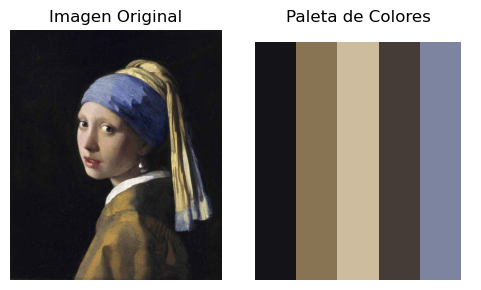

la imagen cargada del pipeline es de <class 'numpy.ndarray'>


ValueError: Found array with dim 3. TSNE expected <= 2.

In [115]:
#Se obtiene la paleta para una image diferente
getColorPallete('img/img2.jpg')

C:\Users\julia\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(


La ruta de la imagen es :img/img3.jpg
El mejor numero de clusters K es: 5


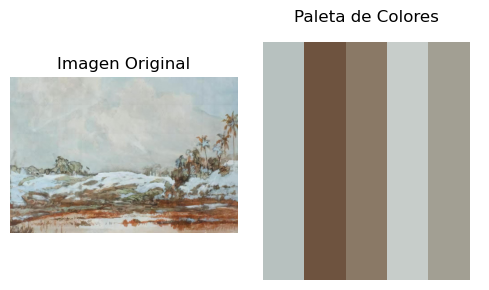

In [16]:
#Se obtiene la paleta para una image diferente
getColorPallete('img/img3.jpg')

C:\Users\julia\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(


La ruta de la imagen es :img/img4.jpg
El mejor numero de clusters K es: 5


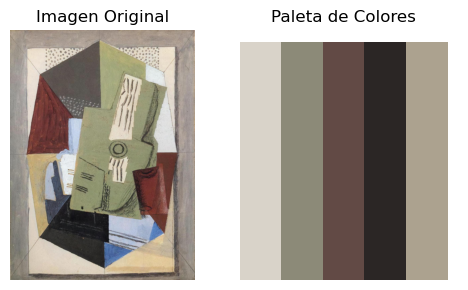

In [17]:
#Se obtiene la paleta para una image diferente
getColorPallete('img/img4.jpg')